# Проект по курсу "Численные методы"

**Описание исследования**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Необходимо построить модель, которая будет уметь ее предсказывать, используя данные о технических характеристиках, комплектации и ценах других автомобилей. **Критерии, которые важны заказчику:** качество предсказания, время обучения модели, время предсказания модели.

**Цель исследования**

Построить несколько моделей для предсказания рыночной стоимости автомобиля и путем сравнения выбрать лучшую

**Задачи исследования**
- Изучить данные, провести предобработку и исследовательский анализ данных данных. Подготовить выборки для обучения моделей
- Обучить разные модели: одна из которых будет LightGBM, а другая - не бустинг.
- Опираясь на критерии заказчика, выберите лучшую модель, проверить её качество на тестовой выборке.

**Описание данных**

Данные находятся в файле /datasets/autos.csv.

**Входные признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак** - Price — цена (евро)

## Устанавливаем пакеты, импортируем библиотеки, задаем константы и пишем функции

In [1]:
!pip install optuna -q
!pip install lightgbm -q
!pip install scikit-learn --upgrade -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error
import optuna
import lightgbm as lgb

from typing import List
import time
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.2

def get_info(df: pd.DataFrame) -> None:
    """
    Выводит информацию о DataFrame: форму, количество строк и столбцов,
    количество пропущенных значений, дубликатов и типы данных.

    Args:
        df: DataFrame для анализа.
    """
    print(f"\n{type(df).__name__} shape: {df.shape}")
    print(f"\n{df.shape[0]:,.0f} rows")
    print(f"\n{df.shape[1]:,.0f} columns")
    print(f'\nMissing Data: \n{df.isnull().sum()}')
    print(f'\nDuplicates: {df.duplicated().sum()}')
    print(f'\nData Types: \n{df.dtypes}')


def plot_discrete_features(df: pd.DataFrame, descrite_cols: List[str]) -> None:
    """
    Строит графики для дискретных признаков в DataFrame.

    Args:
        df: DataFrame с данными.
        descrite_cols: Список названий столбцов с дискретными признаками.
    """
    num_plots = len(descrite_cols)
    num_rows = (num_plots + 1) // 2
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.ravel()
    for i, col in enumerate(descrite_cols):
        sns.countplot(x=col, data=df, ax=axes[i], palette='deep')
        axes[i].set_title(col)

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


def plot_numerical_features(df: pd.DataFrame, numerical_cols: List[str]) -> None:
    """
    Строит гистограммы и boxplot'ы для числовых признаков в DataFrame.

    Args:
        df: DataFrame с данными.
        numerical_cols: Список названий столбцов с числовыми признаками.
    """

    palette = sns.color_palette('deep', len(numerical_cols))
    color_dict = dict(zip(numerical_cols, palette))
    num_cols = len(numerical_cols)
    fig, axes = plt.subplots(nrows=num_cols, ncols=2, figsize=(15, 5*num_cols))

    for i, col in enumerate(numerical_cols):
        # Histogram
        if df[col].nunique() > 50: discrete = False
        else : discrete = True
        sns.histplot(data=df, x=col, ax=axes[i, 0], color=color_dict[col], discrete = discrete)
        axes[i, 0].set_title(f'Histogram {col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(y=df[col], ax=axes[i, 1], color=color_dict[col])
        axes[i, 1].set_title(f'Boxplot {col}')
        axes[i, 1].set_ylabel(col)

    plt.tight_layout()
    plt.show()


def plot_categorical_features(df: pd.DataFrame, categorical_cols: List[str], target_column: str) -> None:
    """
    Строит countplot'ы и boxplot'ы для категориальных признаков в DataFrame,
    показывая их взаимосвязь с целевым признаком.

    Args:
        df: DataFrame с данными.
        categorical_cols: Список названий столбцов с категориальными признаками.
        target_column: Название столбца с целевым признаком.
    """
    palette = sns.color_palette('deep', len(categorical_cols))
    color_dict = dict(zip(categorical_cols, palette))
    cat_cols = len(categorical_cols)
    fig, axes = plt.subplots(nrows=cat_cols, ncols=2, figsize=(15, 5*cat_cols))

    for i, col in enumerate(categorical_cols):
        # Countplot
        sns.countplot(data=df, x=col, ax=axes[i, 0], palette='deep')
        axes[i, 0].set_title(f'Countplot {col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(x=df[col], y=df[target_column], ax=axes[i, 1], palette='deep')
        axes[i, 1].set_title(f'Boxplot {col} vs {target_column}')
        axes[i, 1].set_xlabel(col)
        axes[i, 1].set_ylabel(target_column)

    plt.tight_layout()
    plt.show()



def get_histogram_boxplot(df, col_name):
    fig = make_subplots(rows=1, cols=2,
                    subplot_titles=["Box Plot", "Histogram"], horizontal_spacing=0.2,
                   specs=[[{"type": "box"}, {"type": "histogram"}]])

    fig.add_trace(
        go.Box(y=df[col_name],
              name='Box Plot'),
        row=1, col=1
    )

    fig.add_trace(
        go.Histogram(x=df[col_name],
                    name='Histogram'),
        row=1, col=2
    )

    fig.update_layout(
        title=f'<b>{col_name} Distribution</b>',
        yaxis_title='Frequency',
        plot_bgcolor='black',
        paper_bgcolor='black',
        font_color='white',
        height=600, width=1000
    )


    fig.update_traces(marker_color='magenta', row=1, col=1)
    fig.update_traces(marker_color='#64C9E1', opacity=0.8, row=1, col=2)

    fig.show()


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\abina\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\abina\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\abina\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Загрузка и описание данных

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv', parse_dates = ['DateCreated', 'LastSeen', 'DateCrawled'])
except:
    df = pd.read_csv('autos.csv', parse_dates = ['DateCreated', 'LastSeen', 'DateCrawled'])

display(df.head(3))
get_info(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46



DataFrame shape: (354369, 16)

354,369 rows

16 columns

Missing Data: 
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Duplicates: 4

Data Types: 
DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
Repaired                     object
DateCreated          

In [3]:
# Define the target column
target_column = 'Price'

# Select categorical and numerical columns (initial)
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(exclude=['object']).columns

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_features.tolist())
print("\nNumerical Columns:", numerical_features.tolist())

Target Column: Price

Categorical Columns: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

Numerical Columns: ['DateCrawled', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']


Мы загрузили данные и получили общую информацию: в таблице есть несколько дубликатов и почти во всех категориальных признаках присутствуют пропущенные значения. Привели к правильному типу данных в столбцах `DateCreated`, `LastSeen`, `DateCrawled` и выделили в отдельные переменные количественные, категориальные и целевой признаки.

## Визуализация категориальных признаков

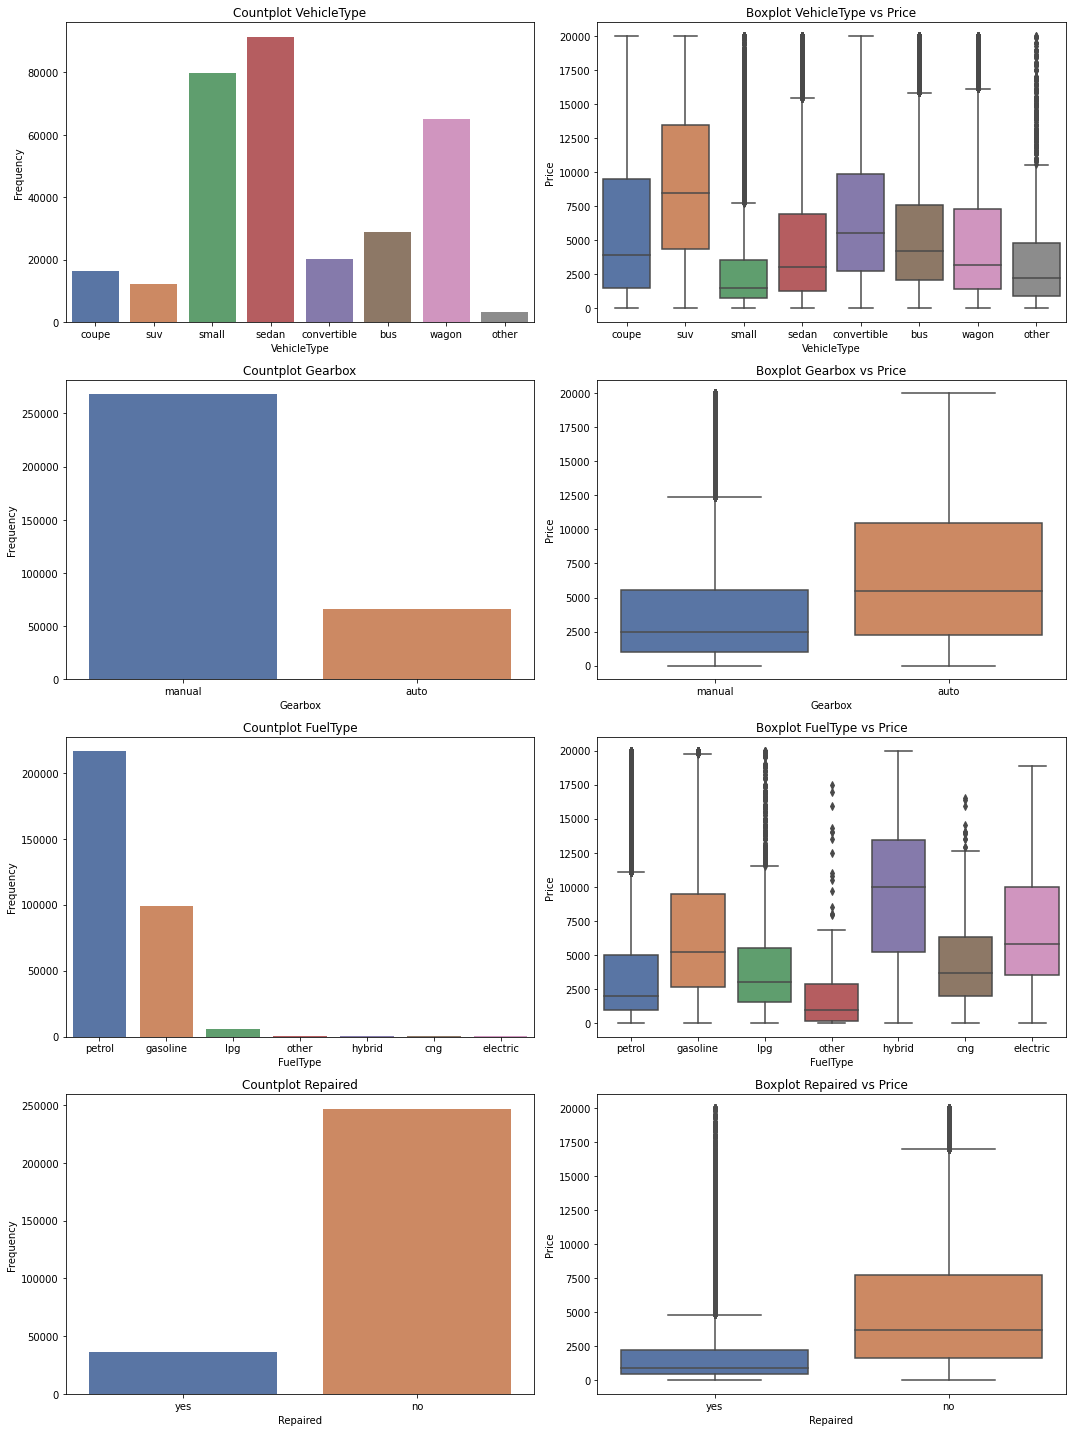

In [ ]:
filtered_cat_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
plot_categorical_features(df, categorical_cols=filtered_cat_cols, target_column=target_column)

In [4]:
for col in categorical_features:
    print(f"\nMissing data in '{col}':\n{df[col].isna().sum()}")


Missing data in 'VehicleType':
37490

Missing data in 'Gearbox':
19833

Missing data in 'Model':
19705

Missing data in 'FuelType':
32895

Missing data in 'Brand':
0

Missing data in 'Repaired':
71154


Во всех категориальных признаках, кроме `Brand` встречаются пропущенные значения. В тех столбцах, где уже есть категория `other`, мы заполним этим же пропуски, а где нет - поставим `missing`.

В столбце `FuelType` есть неявный дубликат, заменим 'gasoline' на 'petrol'.

In [5]:
total_rows = df.shape[0]

df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

# Fill NaN values in categorical features
df['VehicleType'].fillna('other', inplace=True)
df['Gearbox'].fillna('missing', inplace=True)
df['Model'].fillna('other', inplace=True)
df['FuelType'].fillna('other', inplace=True)
df['Repaired'].fillna('missing', inplace=True)
print(f'Missing data \n{df.isna().sum()}')

Missing data 
DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


## Визуализация количественных признаков

In [ ]:
get_histogram_boxplot(df, 'Price')

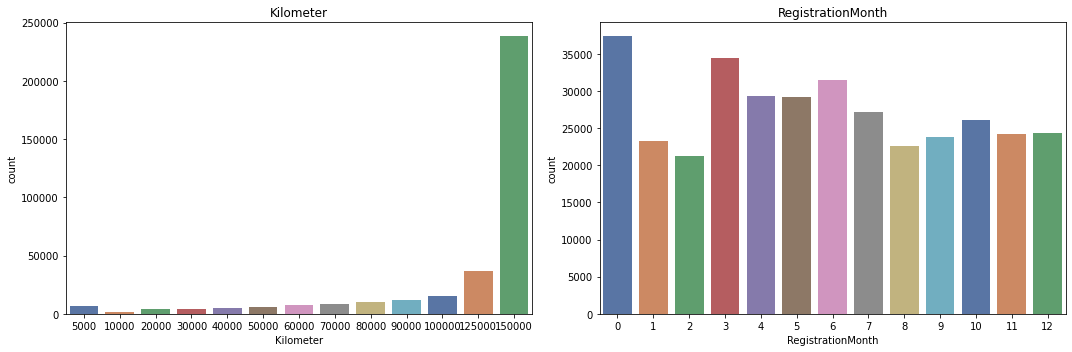

In [ ]:
plot_discrete_features(df, ['Kilometer', 'RegistrationMonth'])

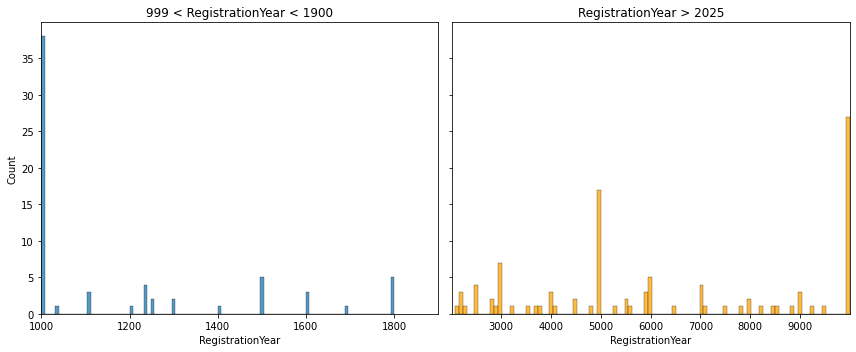

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Первый график (RegistrationYear > 999 and < 1900)
sns.histplot(df[(df['RegistrationYear'] >= 999) & (df['RegistrationYear'] < 1900)]['RegistrationYear'], bins=100, ax=axes[0])
axes[0].set_title('999 < RegistrationYear < 1900')
axes[0].set_xlim(999, 1900)

# Второй график (RegistrationYear > 2020)
sns.histplot(df[df['RegistrationYear'] > 2025]['RegistrationYear'], bins=100, ax=axes[1], color='orange')
axes[1].set_title('RegistrationYear > 2025')
axes[1].set_xlim(2020, df['RegistrationYear'].max())

plt.tight_layout()
plt.show()

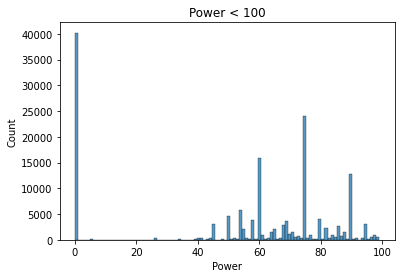

In [ ]:
sns.histplot(df[df['Power'] < 100 ]['Power'], bins=100)
plt.title('Power < 100')
plt.show()

На гистограмме количественного признака `Price` видно, что есть больше 13 тысяч значений, равных нулю. Это скорее всего аномалии, от которых нужно будет избавиться. Оставим только те автомобили, чья стоимость больше 100 евро.

Признак `Kilometer` кажется дискретным, так как состоит из одни и тех же значений пробега машины.

В столбце `RegistrationYear`, в котором должен быть записан год регистрации автомобиля, встречаются значения меньше 1960 и больше 2025. Предположительно, что это аномалии, поэтому мы оставим только релеватные года в диапозоне от 1960 до 2025.

В столбце `Power` есть больше 40 тысяч значений, равных нулю. Предлагаю заменить эти нули на медиану.

In [6]:
# Handle outliers
df = df[~(df['Price'] < 100)]
df = df.loc[~(df['RegistrationYear'] < 1960) & ~(df['RegistrationYear'] > 2016)]
df['Power'] = df.groupby(['Brand', 'Model'])['Power'].transform(lambda x: x.replace(0, x[x > 0].median()))

In [7]:
df = df.drop_duplicates()
left_data = (total_rows - (total_rows - df.shape[0]))/total_rows
print("Left data: {:.4f}".format(left_data))

df.shape

Left data: 0.9229


(327064, 16)

Осталось 92% от изначальных данных, в датасете теперь 327,064 строк.

## Матрица корреляций количественных признаков

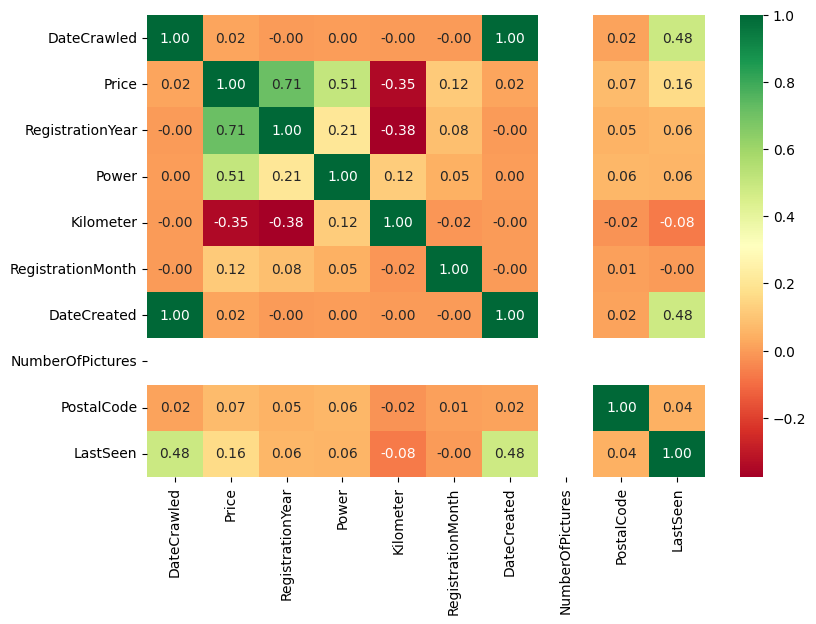

In [ ]:
plt.figure(figsize = (9, 6))

sns.heatmap(df[numerical_features].corr(method='spearman'),
            annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Видно, что признак `NumberOfPictures` никак не коррелирует с другими признаками, так как полностью состоит из одних в нулей. Напомним, что этот столбец показывает количество фотографий автомобиля. Его можно удалить из таблицы.

Из датасета удалим столбцы `DateCrawled` и `DateCreated`, так как они оба обозначают дату создания анкеты, а столбцы `LastSeen`, `RegistrationMonth` и `PostalCode` неинформативные.

- слабая обратная связь между целевым признаком и `Kilometer` - (-0.35)
- сильная связь между между целевым признаком и `RegistrationYear` - 0.71
- умеренная связь между целевым признаков и `Power` - 0.51

Мы заполнили пропуски в категориальных данных, почистили таблицу от выбросов и удалили явные и неявные дубликаты. Решили, что будем удалять столбцы `NumberOfPictures`, `DateCrawled`, `DateCreated`, `LastSeen`, `RegistrationMonth`, `PostalCode`.

## Разделим данные на выборки и построим пайплайн

In [8]:
# Split train data into features and target
X = df.drop(columns=[target_column, 'DateCrawled', 'DateCreated', 'NumberOfPictures',
                             'LastSeen', 'RegistrationMonth', 'PostalCode'])
y = df[target_column]

# Define categorical and numerical features
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numerical_features = ['RegistrationYear', 'Power', 'Kilometer']

#Build Pipeline

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# Preprocess data
X_preprocessed = data_preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Подберем параметры с помощью Optuna для модели LightGBM

In [ ]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'boosting_type': "gbdt",
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        "verbosity": -1,
        'random_state': RANDOM_STATE
    }

    model = lgb.LGBMRegressor(**params)
    rmse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return -np.mean(rmse)


study = optuna.create_study(study_name="LGBM_study", direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Best parameters and RMSE
print("Best parameters:", study.best_params)
print("Best RMSE:", -study.best_value)

In [15]:
X_preprocessed

array([[ 0.        ,  0.        ,  1.        , ..., -1.45403166,
        -0.11992038,  0.58046775],
       [ 0.        ,  1.        ,  0.        , ...,  1.25241209,
         0.36876719, -0.09158134],
       [ 0.        ,  0.        ,  0.        , ...,  0.19990619,
         0.22051366, -0.09158134],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.40152576,
        -0.11992038, -0.09158134],
       [ 0.        ,  0.        ,  0.        , ..., -1.0029577 ,
        -0.1144295 ,  0.58046775],
       [ 0.        ,  0.        ,  0.        , ..., -0.10080978,
        -0.12541125,  0.58046775]])

In [9]:
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Train Model
final_params = {'n_estimators': 621, 'learning_rate': 0.05215334391048413, 'num_leaves': 298, 'max_depth': -1}
start_time = time.time()
lgb_model = lgb.LGBMRegressor(**final_params)
lgb_model.fit(X_train_main, y_train_main)
end_time = time.time()
training_time = end_time - start_time

# Make predictions
start_time = time.time()
lgb_preds = lgb_model.predict(X_val)
end_time = time.time()
prediction_time = end_time - start_time
rmse_score = root_mean_squared_error(y_val, lgb_preds)

print(f'RMSE: {rmse_score}')
print(f'Время обучения модели: {training_time:.2f}')
print(f'Время предсказания модели: {prediction_time:.2f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 899
[LightGBM] [Info] Number of data points in the train set: 209320, number of used features: 289
[LightGBM] [Info] Start training from score 4645.447368
RMSE: 1549.2516988409427
Время обучения модели: 4.85
Время предсказания модели: 0.56


## Подберем параметры для модели DecisionTreeRegressor с помощью RandomizedSearchCV

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

treeregr_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__min_samples_leaf': range(1, 10),
        'models__min_samples_split': range(2, 10),
        'models__splitter': ['best', 'random'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    treeregr_final,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)
print('Best model:\n\n', randomized_search.best_estimator_)
print ('Best score:', -randomized_search.best_score_)

Best model:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('num', MinMaxScaler(),
                      

In [11]:
dt_results = pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score')
print(f"Training time: {dt_results['mean_fit_time'][5]}")
print(f"Prediction time: {dt_results['mean_score_time'][5]}")

Training time: 21.20054636001587
Prediction time: 0.6558069229125977


## Подберем параметры для модели RandomForestRegressor с помощью RandomizedSearchCV

In [12]:
rf_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestRegressor(random_state=RANDOM_STATE))
])


rf_grid = [
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 120, 150],
        'models__max_depth': [None,1,3,5,7,9],
        'models__max_features': range(1,11),
        'models__min_samples_split':range(2, 10),
        'models__min_samples_leaf':[1,3,5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

rf_search = RandomizedSearchCV(
    rf_final,
    rf_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print('Best model:\n\n', rf_search.best_estimator_)
print ('Best score:', -rf_search.best_score_)

Best model:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('num', MinMaxScaler(),
                      

In [15]:
rf_results = pd.DataFrame(rf_search.cv_results_).sort_values(by='rank_test_score')
print(f"Training time: {rf_results['mean_fit_time'][8]}")
print(f"Prediction time: {rf_results['mean_score_time'][8]}")

Training time: 120.11522679328918
Prediction time: 6.577210903167725


Выбрали три модели для предсказания: LightGBM, RandomForestRegressor, DecisionTreeRegressor. Для каждой подобрали гиперпараметры и посчитали метрику RMSE , время обучения и предсказания.

| Model  |      Cross-Validation RMSE     |   Training Time| Prediction Time|
|----------|:-------------:|------:|------:|
|LightGBM| 1549.25|4.85 | 0.56 |
|Random Forest| 1635.75|120.11|6.57|
|Decision Tree| 1827.29|21.2 | 0.65 |


Опираясь на критерии заказчика (качество предсказания, время обучения модели, время предсказания модели), выберем LightGBM лучшей моделью.

In [46]:
final_preds = lgb_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_preds)
print(final_rmse)

1520.844008875053


## Общий вывод

1. Во-первых, мы изучили данные. Заполнили пропущенные значения, обработали аномалии в столбцах, удалили дубликаты. Удалили неинформативные признаки из таблицы: `DateCrawled`, `DateCreated`, `NumberOfPictures`, `LastSeen`, а столбец `PostalCode` стал индексом.
2. Разделили данные на обучающую, валидационную, тестовую выборки.
3. Выбрали три модели: `LightGBM`, `RandomForestRegressor`, `DecisionTreeRegressor`. Для `LightGBM` подобрали параметры с помощью Optuna, для `RandomForestRegressor` и `DecisionTreeRegressor` - RandomizedSearchCV.
4. Лучшей моделью по критериям качества заказчика получилась `LightGBM`. Метрика RMSE на тестовой выборке - 1556.03. Время обучения - 3.97 сек, время предсказания - 0.68.